In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8') 

import warnings
warnings.filterwarnings('once')

In [139]:
# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [140]:
# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

In [141]:
path = r'Ventas por mes.csv'
sales = pd.read_csv(path)
sales.head(4)

,Fact Real,YearMonthnumber
0,133659.6003,2014/01
1,45445.5470,2014/02
2,183719.5746,2014/03
3,81818.2348,2014/04


In [142]:
sales = sales.rename(columns={'YearMonthnumber':'date','Fact Real':'Sales'})
sales['date'] = pd.to_datetime(sales['date'],format='%Y-%m-%d')
sales = sales.set_index('date')
sales = sales.asfreq('MS')

sales = sales['Sales']

In [143]:
sales

date
2014-01-01    133659.60030
2014-02-01     45445.54700
2014-03-01    183719.57460
2014-04-01     81818.23480
2014-05-01    128570.50440
2014-06-01    113614.23030
2014-07-01    131240.12680
2014-08-01    158476.62220
2014-09-01    248411.33120
2014-10-01    146494.08730
2014-11-01    270847.00260
2014-12-01    313657.73720
2015-01-01    149227.37410
2015-02-01     77426.23175
2015-03-01    198338.45730
2015-04-01    132947.57220
2015-05-01    138114.25280
2015-06-01     99908.00127
2015-07-01    124642.54160
2015-08-01    198205.92770
2015-09-01    288557.17550
2015-10-01     98587.64940
2015-11-01    195947.75860
2015-12-01    191240.61420
2016-01-01    170092.47020
2016-02-01    202054.80830
2016-03-01    171177.69890
2016-04-01    205653.24160
2016-05-01    269908.03330
2016-06-01    156786.88530
2016-07-01    152489.89890
2016-08-01    177218.80510
2016-09-01    162496.51440
2016-10-01    209505.18020
2016-11-01    298023.26600
2016-12-01    367431.59930
2017-01-01    291624.22

In [144]:
sales.index[33]

Timestamp('2016-10-01 00:00:00', freq='MS')

Fechas train : 2014-01-01 00:00:00 --- 2016-10-01 00:00:00  (n=34)
Fechas test  : 2016-10-01 00:00:00 --- 2017-12-01 00:00:00  (n=15)


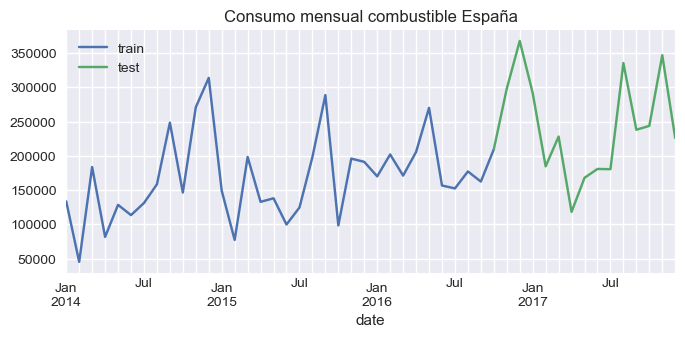

In [169]:
# Fechas Train-test
# ======================================================================================
fin_train = '2016-10-01 00:00:00'
print(
    f"Fechas train : {sales.index.min()} --- {sales.loc[:fin_train].index.max()}  "
    f"(n={len(sales.loc[:fin_train])})"
)
print(
    f"Fechas test  : {sales.loc[fin_train:].index.min()} --- {sales.loc[:].index.max()}  "
    f"(n={len(sales.loc[fin_train:])})"
)
sales_train = sales.loc[:fin_train]
sales_test  = sales.loc[fin_train:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
sales_train.plot(ax=ax, label='train')
sales_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -4.604373698511155, p-value: 0.00012679308490072655
KPSS Statistic: 0.6281722650946001, p-value: 0.020075248627763623

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -3.6405556588849706, p-value: 0.0050313818341363985
KPSS Statistic: 0.4999999999999928, p-value: 0.041666666666668295

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -3.058278525234853, p-value: 0.02979882680149549
KPSS Statistic: 0.2660526098468887, p-value: 0.1


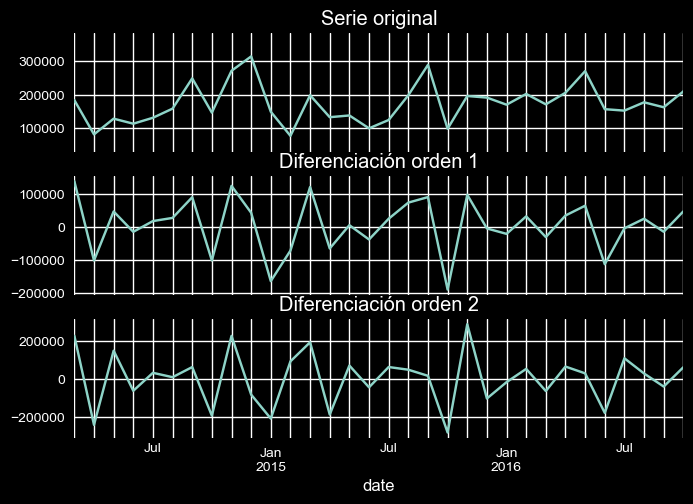

In [186]:
# ==============================================================================
warnings.filterwarnings("ignore")

sales_diff_1 = sales_train.diff().dropna()
sales_diff_2 = sales_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(sales)
kpss_result = kpss(sales)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(sales_diff_1)
kpss_result = kpss(sales.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(sales_diff_2)
kpss_result = kpss(sales.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
sales.plot(ax=axs[0], title='Serie original')
sales_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
sales_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

## Graficos de Autocorrelacion (q)

Text(0.5, 1.0, 'Autocorrelación serie diferenciada (order=1)')

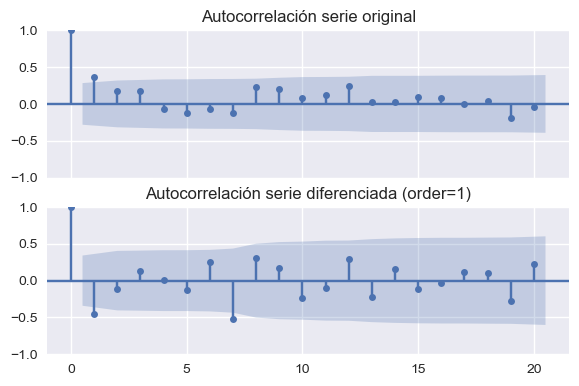

In [171]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(sales, ax=axs[0], lags=20, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(sales_diff_1, ax=axs[1], lags=20, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)')

## Grafico Autocorrelacion Parcial (p)

c:\Users\Ernes\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


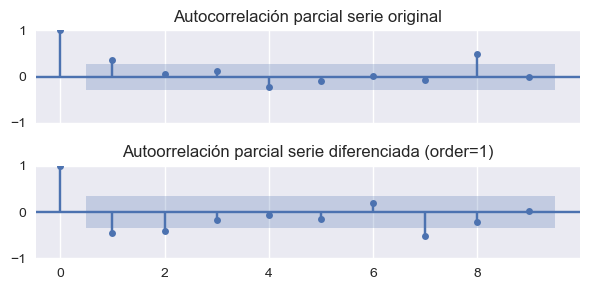

In [172]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(sales, ax=axs[0], lags=9, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(sales_diff_1, ax=axs[1], lags=9, alpha=0.05,method='ywm')
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout()

# Descomposicion de la serie.

In [173]:
sales_stl = STL(sales).fit()
sales_add = seasonal_decompose(sales,model='multiplicative')
sales_mult = seasonal_decompose(sales,model='additive')

print(f'Promedio residuales descomposición aditiva: {sales_add.resid.mean()}')
print(f'Promedio residuales descomposición multiplicativa: {sales_mult.resid.mean()}')
print(f'Promedio residuales descomposición STL: {sales_stl.resid.mean()}')

Promedio residuales descomposición aditiva: 1.00414820023972
Promedio residuales descomposición multiplicativa: -622.770081134247
Promedio residuales descomposición STL: -51.83123256100286


Text(0.5, 0.98, 'Descomposición de la serie original vs serie diferenciada')

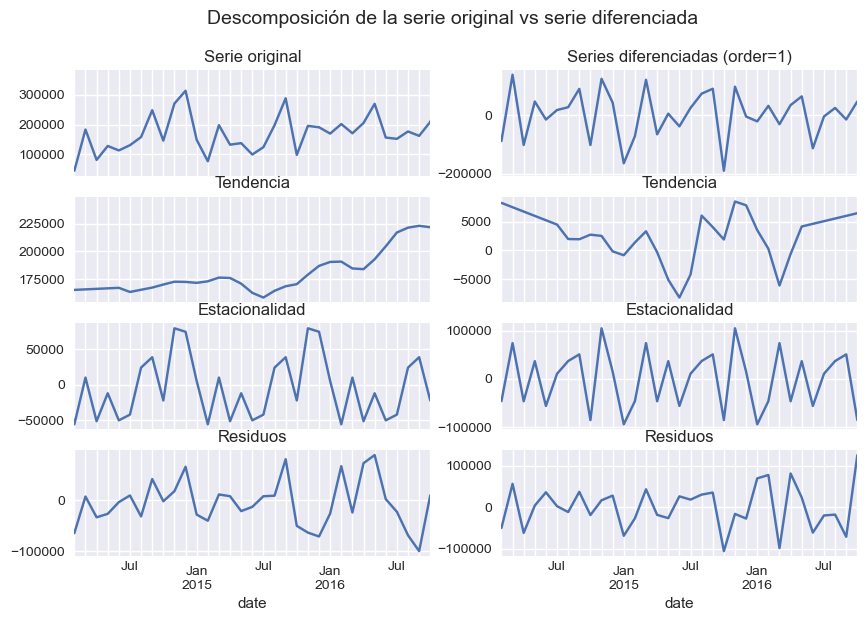

In [174]:
res_decompose = seasonal_decompose(sales, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(sales_diff_1, model='additive', extrapolate_trend='freq')

#Serie original
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)

res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)

res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)

res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)

# Serie diferenciada
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)

res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)

res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)

res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)

fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)

In [151]:
datos_diff_1_12 = sales_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -0.11284557663760063, p-value: 0.948143938158652
KPSS Statistic: 0.0920652019333877, p-value: 0.1


In [175]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')

modelo = SARIMAX(endog = sales_train, order = (0, 1, 0), seasonal_order = (0, 1, 0, 10))
modelo_res = modelo.fit(disp=0)

warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 10)   Log Likelihood                -305.595
Date:                            Fri, 17 Oct 2025   AIC                            613.189
Time:                                    16:09:56   BIC                            614.325
Sample:                                01-01-2014   HQIC                           613.475
                                     - 10-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.26e+10   2.65e+09      4.749      0.000     7.4e+09    1.78e+10
===================================================================================
Ljung-Box (L1) (Q):                   3.91   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.05   Prob(JB):                         0.91
Heteroskedasticity (H):               0.90   Skew:                            -0.14
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
predicciones = modelo_res.get_forecast(steps=len(sales_test)).predicted_mean
predicciones.name = 'predicciones'
display(predicciones.head(4))

2016-11-01    188357.0362
2016-12-01    220319.3743
2017-01-01    189442.2649
2017-02-01    223917.8076
Freq: MS, Name: predicciones, dtype: float64

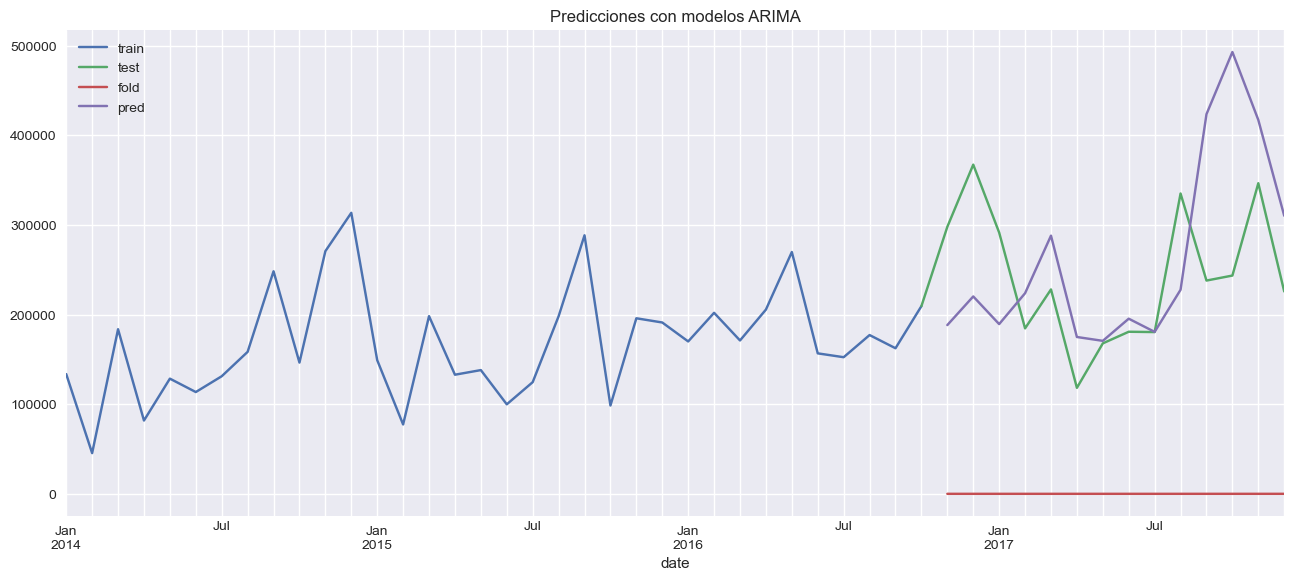

In [176]:
fig, ax = plt.subplots(figsize=(14, 6))
sales_train.plot(ax=ax, label='train')
sales_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='prediccion')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend()

In [155]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 10),
                                maxiter=100
                            )
             )

cv = TimeSeriesFold(
        steps              = 10,
        initial_train_size = len(sales_train),
        refit              = True,
        fixed_train_size   = False,
)
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = sales,
                            cv                    = cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))

Information of folds
--------------------
Number of observations used for initial training: 34
Number of observations used for backtesting: 14
    Number of folds: 2
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-10-01 00:00:00  (n=34)
    Validation: 2016-11-01 00:00:00 -- 2017-08-01 00:00:00  (n=10)
Fold: 1
    Training:   2014-01-01 00:00:00 -- 2017-08-01 00:00:00  (n=44)
    Validation: 2017-09-01 00:00:00 -- 2017-12-01 00:00:00  (n=4)



c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2 [00:00<?, ?it/s]

,mean_absolute_error
0,87887.831979


,fold,pred
2016-11-01,0,188357.0362
2016-12-01,0,220319.3743
2017-01-01,0,189442.2649
2017-02-01,0,223917.8076


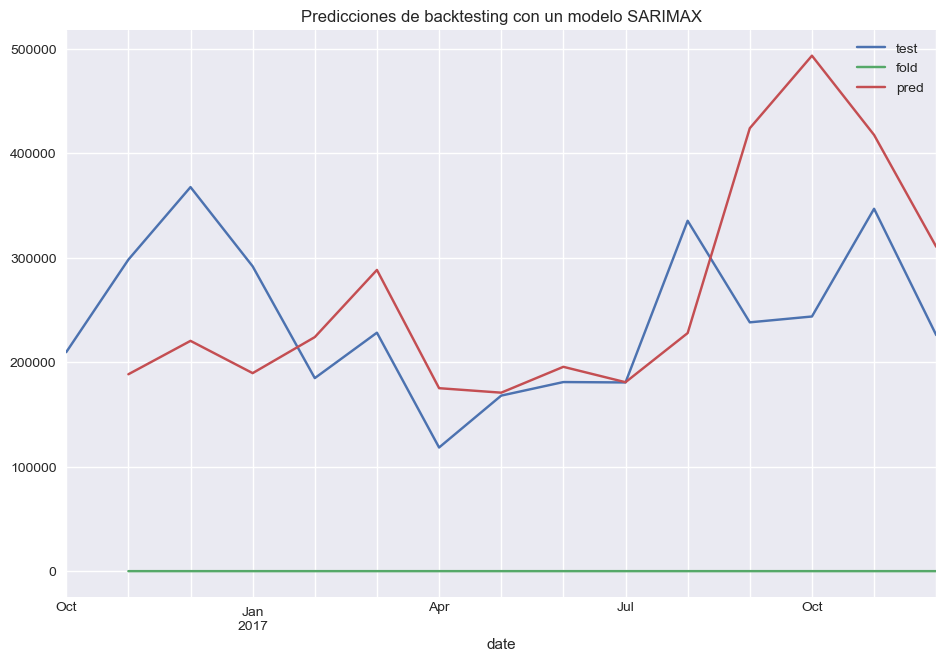

In [177]:
fig, ax = plt.subplots(figsize=(10, 7))
sales.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend()

In [202]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12),(1, 1, 0,12),(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

In [203]:
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(sales_train),
        refit              = True,
        fixed_train_size   = False,
    )

resultados_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = sales,
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   suppress_warnings_fit = True,
               )
resultados_grid.head(5)

Number of models compared: 60.


c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


params grid:   0%|          | 0/60 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
0,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",51079.187973,"(1, 1, 1)","(1, 1, 0, 12)",None
1,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",51079.187973,"(1, 1, 1)","(1, 1, 0, 12)",n
2,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",51939.651385,"(1, 1, 1)","(1, 1, 0, 12)",c
3,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",52768.555991,"(1, 1, 0)","(1, 1, 0, 12)",c
4,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",52858.469232,"(1, 1, 0)","(1, 1, 0, 12)",None


In [204]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), maxiter=250),
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(sales_train),
        refit              = True,
)
metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = sales,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                suppress_warnings_fit = True,
                              )

c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2 [00:00<?, ?it/s]

In [184]:
plt.style.use('fast')

Metrica (mean absolute error) del modelo grid search:


,mean_absolute_error
0,51125.497552


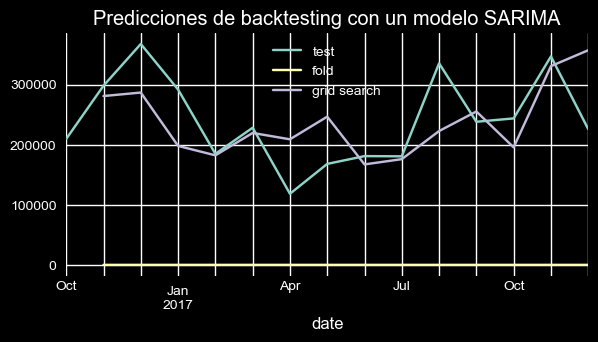

In [205]:
print("Metrica (mean absolute error) del modelo grid search:")
display(metrica_m1)


fig, ax = plt.subplots(figsize=(6, 3))
sales.loc[fin_train:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m1.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

In [190]:
# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

In [197]:
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)
modelo = auto_arima(
            y                 = sales_train,
            start_p           = 0,
            start_q           = 0,
            max_p             = 2,
            max_q             = 1,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,   # periodicidad de la estacionalidad
            d                 = 1, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=845.031, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=842.945, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=837.559, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=832.268, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=840.987, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=830.471, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=832.434, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=832.527, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=836.009, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=828.821, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=830.690, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=830.675, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=832.534, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12]             

In [198]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = sales,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                suppress_warnings_fit = True
                              )

c:\Users\Ernes\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2 [00:00<?, ?it/s]

Metric (mean_absolute_error) del modelo auto arima:


,mean_absolute_error
0,56573.358862


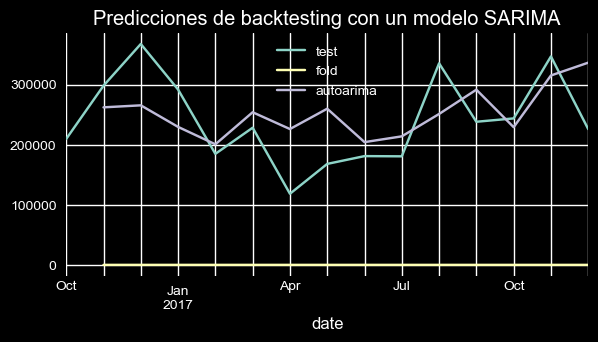

In [199]:

print("Metric (mean_absolute_error) del modelo auto arima:")
display(metrica_m2)

fig, ax = plt.subplots(figsize=(6, 3))
sales.loc[fin_train:].plot(ax=ax, label='test')

predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})

predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()